# BIRCH (Balanced Iterative Reducing and Clustering using Hierarchies)
```
1. 使用階層式分群, tree的節點是複合的(B+ Tree), 稱為CF Tree, 每個節點是CF(Cluster Feature)組成, CF = (數量, 向量和, 向量平方和), 一個CF代表"一坨資料", 所以他是memory efficient
   1. 演算法步驟看下面的圖
   2. B+ Tree Demo可看 https://www.cs.usfca.edu/~galles/visualization/BPlusTree.html

2. 兩個參數要調1. branching factor(B)  2. threshold(T), B是nonleaf node子節點上限, T是CF半徑的上限, 目前怎麼調參數尚未鑽研, 因為我覺得應該用不到
3. 關於距離的算法, X0(群中心) LS(向量和) SS(向量平方和) CF自身的半徑 等等, 還有D0 ~ D4 4種算群距離的方式, 可參考 http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.17.2504&rep=rep1&type=pdf

4. 可以自己決定群數(參數理群數也可給定) 跟k-means一樣一般性的分群, 可去除雜訊點, 可以對付大量的資料(但是你的threshold要給定好)
5. 官網認為維度20維以上就別用了, 選MiniBatchKMeans比較好 => 
Birch does not scale very well to high dimensional data. As a rule of thumb if n_features is greater than twenty, it is generally better to use MiniBatchKMeans.
If the number of instances of data needs to be reduced, or if one wants a large number of subclusters either as a preprocessing step or otherwise, Birch is more useful than MiniBatchKMeans.
6. 參考資料: http://www.voidcn.com/blog/u014380418/article/p-4511882.html
            
```

這是我找到最簡單的說明方法, 其實這個演算法應該是很複雜的...


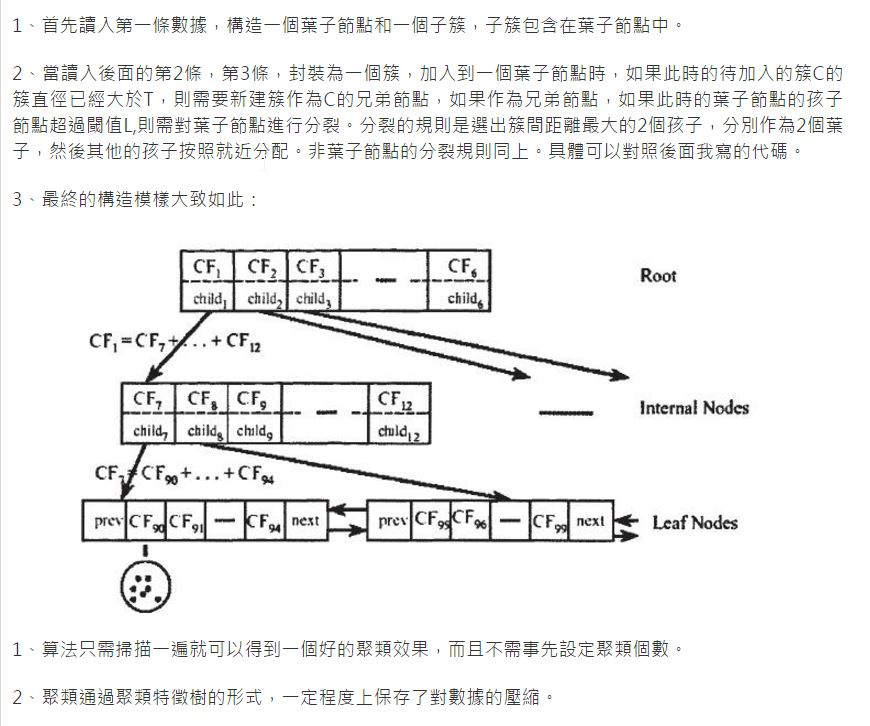

In [2]:
from IPython.display import Image
print('這是我找到最簡單的說明方法, 其實這個演算法應該是很複雜的...')
Image('Birch.jpg')

中心 群半徑 群直徑


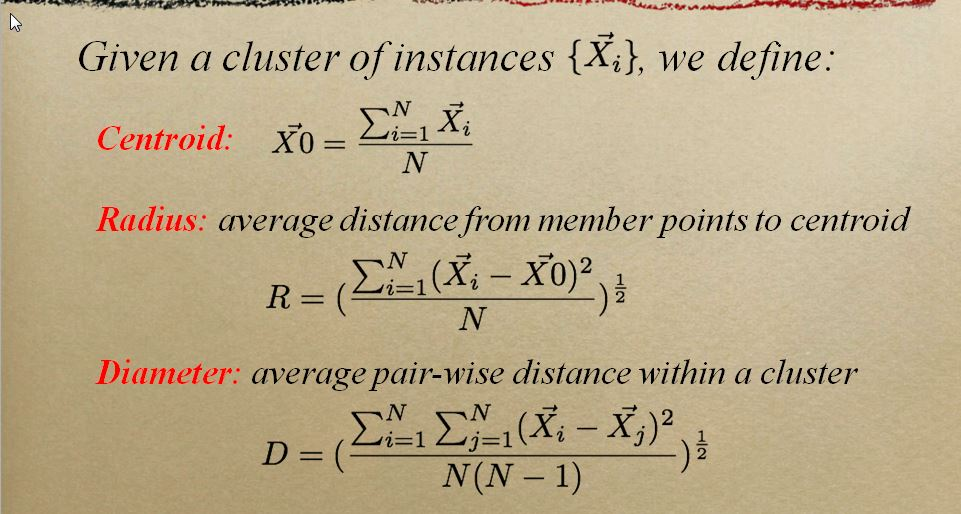

In [24]:
from IPython.display import Image
print("中心 群半徑 群直徑")
Image('birch-alg2.jpg')

5種群距離的算法, 一般都使用D2 或 D3


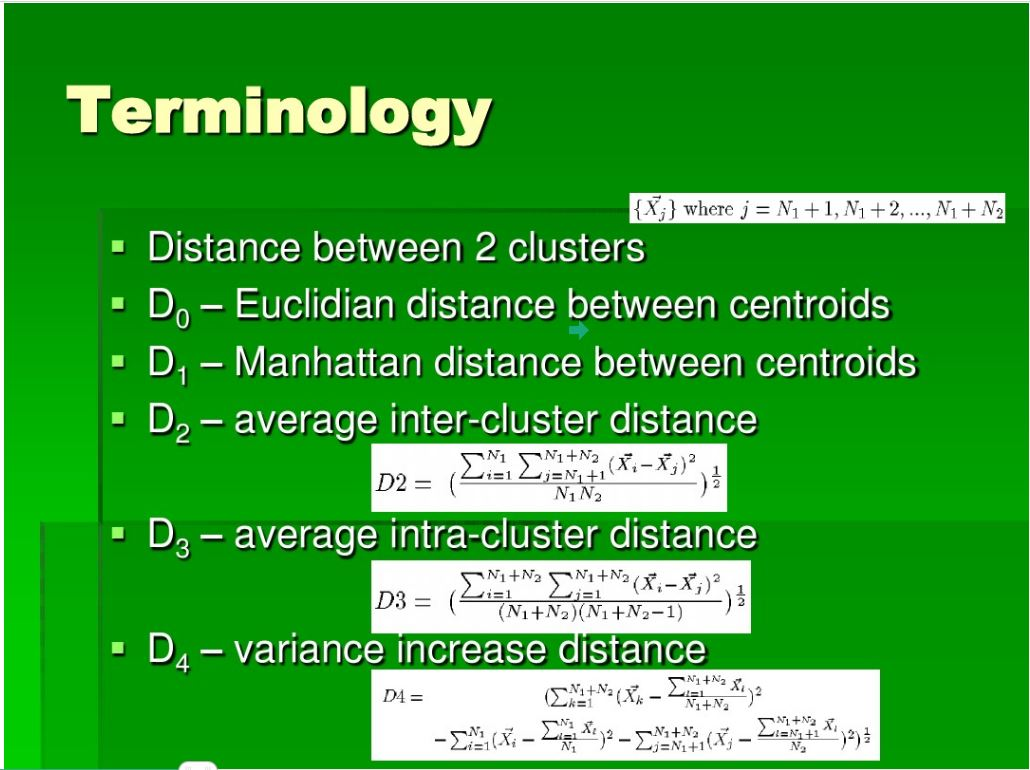

In [22]:
from IPython.display import Image
print("5種群距離的算法, 一般都使用D2 或 D3")
Image('birch-alg.jpg')

In [2]:
%reset -f
%pylab inline
import sys, codecs, pandas as pd, numpy as np, os, re, traceback, pprint, sqlite3, importlib
import jieba, jieba.analyse
from __future__ import division, unicode_literals, with_statement, print_function
from sklearn import datasets
from contextlib import closing

class DataSources(object):    
    def sklearnDs(self):
        return sqlite3.connect('sklearnDs.sqlite')

ds = DataSources()

Populating the interactive namespace from numpy and matplotlib


In [3]:
# 抓出頻果新聞資料
apple78Df = None
with closing(ds.sklearnDs()) as sklearnConn:
    apple78Df = pd.read_sql('''
        select forum, subject, term, keyword, content, pageurl
          from tb_apple_20160701_20160823_02
         order by batchno
    ''', sklearnConn)
apple78Df

,forum,subject,term,keyword,content,pageurl
0,politics,軍人虐狗 國防部長上莒光園地：絕不容許再發生,更新 影片 海軍陸戰隊 事件 國防部長 馮世寬 火線 道歉 莒光 馮世寬 官兵 殘忍 國軍 ...,馮世寬 馮世寬 馮世寬 馮世寬 馮世寬 生命 生命 生命 生命 生命 官兵 官兵 官兵 衛國...,（更新：新增影片） 海軍陸戰隊虐狗事件引發眾怒，國防部長馮世寬不但親上火線道歉，今天「莒光園...,http://www.appledaily.com.tw/realtimenews/arti...
1,entertainment,田馥甄舉杯慶《日常》 佼佼：小心變張清芳,新聞 田馥甄 Hebe 記者會 現場 斯洛伐克 家居 模樣 日常生活 專輯 日常 曲目 曝光...,田馥甄 田馥甄 田馥甄 田馥甄 專輯 專輯 專輯 專輯 專輯 日常生活 日常生活 日常生活 ...,(新增動新聞) 田馥甄（Hebe）今舉辦發片記者會，現場打造斯洛伐克家居模樣，展現出她的日常...,http://www.appledaily.com.tw/realtimenews/arti...
2,fashion,Rimowa聯名蕭青陽騎白馬 徐佳瑩歌聲助陣,新聞 德國 行李箱 品牌 發表 台灣 設計師 青陽 合作 台灣 青陽 作品 白馬 靈感 設計...,青陽 青陽 青陽 青陽 青陽 青陽 青陽 青陽 徐佳瑩 徐佳瑩 徐佳瑩 白馬 白馬 白馬 作...,（新增動新聞） 德國知名行李箱品牌Rimowa，發表首次與台灣設計師蕭青陽合作的台灣獨賣限定...,http://www.appledaily.com.tw/realtimenews/arti...
3,fashion,【女神進化】天心戴蛇形陀飛輪錶 許願升級魅惑術,新聞 天心 金融業 男友 分手 寶格麗 BVLGARI 發表 珠寶 許願 個性 女人 學習 ...,serpenti serpenti serpenti serpenti serpenti s...,（新增動新聞）天心和金融業男友剛分手，今為寶格麗（BVLGARI）發表Serpenti新珠寶...,http://www.appledaily.com.tw/realtimenews/arti...
4,property,房仲6月交易價量 雙北市逆轉勝,影片 房仲 房市 交易 台灣 逆轉勝 永慶 房產 集團 中心 全台 房市 交易量 北市 桃園...,交易量 交易量 交易量 交易量 北市 北市 北市 北市 北市 台南 台南 台南 台南 房市 ...,(新增：影片) 各家房仲發布6月房市交易現況，出現北台灣「逆轉勝」。其中，永慶房產集團研展中...,http://www.appledaily.com.tw/realtimenews/arti...
5,sports,【強】王建民2局無失分 第5勝進帳,更新 更新 影片 比賽 皇家 終結者 戴維斯 Wade Davis 救援 延長 王建民 演出...,皇家 皇家 皇家 皇家 皇家 皇家 皇家 皇家 皇家 皇家 皇家 皇家 皇家 皇家 王建民 ...,更新：新增球評說法 (更新影片)(更進比賽進度) 皇家終結者戴維斯(Wade Davis)本...,http://www.appledaily.com.tw/realtimenews/arti...
6,politics,巴拉圭農牧業者：希望高品質牛肉 供應台灣家庭,更新 影片 巴拉圭 鄉村 協會 時間 中午 款待 台灣 總統 蔡英文 巴拉圭 副總統 法拉 ...,巴拉圭 巴拉圭 巴拉圭 巴拉圭 巴拉圭 巴拉圭 巴拉圭 巴拉圭 巴拉圭 巴拉圭 巴拉圭 巴拉...,（更新：新增影片）巴拉圭鄉村協會在當地時間30日中午設宴款待台灣總統蔡英文，巴拉圭副總統艾法...,http://www.appledaily.com.tw/realtimenews/arti...
7,life,台北-台中天天通勤 高鐵哥告訴你真相,更新 影片 高鐵 生活 高鐵 天天 通勤 交通工具 網友 MOBILE01 台中 台北 天天...,高鐵 高鐵 高鐵 高鐵 高鐵 高鐵 高鐵 高鐵 公司 公司 公司 公司 公司 公司 公司 公...,（更新：新增影片）高鐵可以達成各地生活一日圈，但問題是高鐵雖然快又方便，卻能當成「天天」通勤...,http://www.appledaily.com.tw/realtimenews/arti...
8,local,夜偷24斤生猛海鮮 門把留1枚指紋落網,更新 影像 影片 新北市 許姓 男子 清晨 金山區 台2線 海產 徒手 拉開 生鏽 欄杆 窗...,海產 海產 海產 海產 海產 金山區 金山區 指紋 指紋 許姓 許姓 黃酒 海螺 畫面 畫面...,(更新：增加內容、影像、影片)新北市30歲許姓男子，去年5月26日清晨5時許，見金山區台2線...,http://www.appledaily.com.tw/realtimenews/arti...
9,local,【專業文】分辨正港UA 專家有4招,更新 影片 智慧財產權 案件 刑事警察 大隊 高雄市 早市 攤商 仿冒 服飾 代理 隊長 蔡...,正品 正品 正品 正品 正品 正品 正品 正品 under under under unde...,（更新：新增影片）專責偵辦侵害智慧財產權案件的保二總隊刑事警察大隊，這次在高雄市區早市，查獲...,http://www.appledaily.com.tw/realtimenews/arti...


## threshold = 0.5  run到爆記憶體重開機, 降維度又失真..., 
## threshold = 1 ~ 1.5 全部資料被分為同一群
## 我看高維度的資料就放棄他好了...

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import Birch
from sklearn.neighbors import NearestNeighbors

vec = TfidfVectorizer()
X = vec.fit_transform(apple78Df.term)

bch = Birch(threshold=1, n_clusters=13)
bch.fit(X)
s = pd.Series(bch.labels_)
s.value_counts()

In [4]:
# 因為爆記憶體, 同樣只抓取前1000筆資料分群, threshold - 0.6
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import Birch
from sklearn.neighbors import NearestNeighbors

vec = TfidfVectorizer()
X = vec.fit_transform(apple78Df[:1000].term)

bch = Birch(threshold=.6, n_clusters=13)
bch.fit(X, apple78Df[:1000].forum)
s = pd.Series(bch.labels_)
s.value_counts()

0     684
1      77
4      46
12     40
8      28
5      28
2      24
9      23
3      16
6      11
7      10
11      7
10      6
dtype: int64

In [6]:
from sklearn import metrics

labels_true, labels = apple78Df[:1000].forum, bch.labels_
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f" % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))

Homogeneity: 0.244
Completeness: 0.427
V-measure: 0.311
Adjusted Rand Index: 0.047
Adjusted Mutual Information: 0.219
Silhouette Coefficient: 0.019


In [32]:
# 設定grp後可觀察分群的狀況, 群內的文章相似度並不像是同一群的...
grp = 0
pre1000 = apple78Df[:1000]
print(pre1000[(bch.labels_ == grp)].forum.value_counts())
pre1000[(bch.labels_ == grp)] # & (pre1000.forum == '3c')

international    154
life             128
entertainment     71
local             69
finance           48
strange           39
forum             30
politics          28
3c                27
sports            27
animal            25
fashion           21
property          17
Name: forum, dtype: int64


,forum,subject,term,keyword,content,pageurl
1,entertainment,田馥甄舉杯慶《日常》 佼佼：小心變張清芳,新聞 田馥甄 Hebe 記者會 現場 斯洛伐克 家居 模樣 日常生活 專輯 日常 曲目 曝光...,田馥甄 田馥甄 田馥甄 田馥甄 專輯 專輯 專輯 專輯 專輯 日常生活 日常生活 日常生活 ...,(新增動新聞) 田馥甄（Hebe）今舉辦發片記者會，現場打造斯洛伐克家居模樣，展現出她的日常...,http://www.appledaily.com.tw/realtimenews/arti...
2,fashion,Rimowa聯名蕭青陽騎白馬 徐佳瑩歌聲助陣,新聞 德國 行李箱 品牌 發表 台灣 設計師 青陽 合作 台灣 青陽 作品 白馬 靈感 設計...,青陽 青陽 青陽 青陽 青陽 青陽 青陽 青陽 徐佳瑩 徐佳瑩 徐佳瑩 白馬 白馬 白馬 作...,（新增動新聞） 德國知名行李箱品牌Rimowa，發表首次與台灣設計師蕭青陽合作的台灣獨賣限定...,http://www.appledaily.com.tw/realtimenews/arti...
3,fashion,【女神進化】天心戴蛇形陀飛輪錶 許願升級魅惑術,新聞 天心 金融業 男友 分手 寶格麗 BVLGARI 發表 珠寶 許願 個性 女人 學習 ...,serpenti serpenti serpenti serpenti serpenti s...,（新增動新聞）天心和金融業男友剛分手，今為寶格麗（BVLGARI）發表Serpenti新珠寶...,http://www.appledaily.com.tw/realtimenews/arti...
4,property,房仲6月交易價量 雙北市逆轉勝,影片 房仲 房市 交易 台灣 逆轉勝 永慶 房產 集團 中心 全台 房市 交易量 北市 桃園...,交易量 交易量 交易量 交易量 北市 北市 北市 北市 北市 台南 台南 台南 台南 房市 ...,(新增：影片) 各家房仲發布6月房市交易現況，出現北台灣「逆轉勝」。其中，永慶房產集團研展中...,http://www.appledaily.com.tw/realtimenews/arti...
6,politics,巴拉圭農牧業者：希望高品質牛肉 供應台灣家庭,更新 影片 巴拉圭 鄉村 協會 時間 中午 款待 台灣 總統 蔡英文 巴拉圭 副總統 法拉 ...,巴拉圭 巴拉圭 巴拉圭 巴拉圭 巴拉圭 巴拉圭 巴拉圭 巴拉圭 巴拉圭 巴拉圭 巴拉圭 巴拉...,（更新：新增影片）巴拉圭鄉村協會在當地時間30日中午設宴款待台灣總統蔡英文，巴拉圭副總統艾法...,http://www.appledaily.com.tw/realtimenews/arti...
7,life,台北-台中天天通勤 高鐵哥告訴你真相,更新 影片 高鐵 生活 高鐵 天天 通勤 交通工具 網友 MOBILE01 台中 台北 天天...,高鐵 高鐵 高鐵 高鐵 高鐵 高鐵 高鐵 高鐵 公司 公司 公司 公司 公司 公司 公司 公...,（更新：新增影片）高鐵可以達成各地生活一日圈，但問題是高鐵雖然快又方便，卻能當成「天天」通勤...,http://www.appledaily.com.tw/realtimenews/arti...
9,local,【專業文】分辨正港UA 專家有4招,更新 影片 智慧財產權 案件 刑事警察 大隊 高雄市 早市 攤商 仿冒 服飾 代理 隊長 蔡...,正品 正品 正品 正品 正品 正品 正品 正品 under under under unde...,（更新：新增影片）專責偵辦侵害智慧財產權案件的保二總隊刑事警察大隊，這次在高雄市區早市，查獲...,http://www.appledaily.com.tw/realtimenews/arti...
11,local,變態殺童男李靖 猥褻10少年判刑20年,更新 新聞 新竹市 林姓 小六 男童 命案 社會 檢警 發現 少年 李靖 猥褻 強制猥褻罪 ...,李靖 李靖 李靖 李靖 李靖 李靖 李靖 李靖 李靖 李靖 李靖 李靖 李靖 少年 少年 少...,（更新：動新聞）新竹市林姓小六男童去年5月遭拐殺命案震驚社會，檢警事後陸續發現另有10名少年...,http://www.appledaily.com.tw/realtimenews/arti...
12,entertainment,【甜蜜放閃】陳怡蓉926清邁嫁醫美名醫,新聞 陳怡蓉 醫美診所 執行長 交往 男方 求婚 長輩 商量 醫療 集團 花園 時尚 晚宴 ...,陳怡蓉 陳怡蓉 陳怡蓉 陳怡蓉 陳怡蓉 陳怡蓉 林莉 林莉 林莉 林莉 林莉 婚紗 婚紗 婚...,（新增動新聞）陳怡蓉和醫美診所執行長薛博仁交往2年，期間男方求婚３次，不過婚期始終未定，今天...,http://www.appledaily.com.tw/realtimenews/arti...
13,local,【被興航撞的小黃現況】運將：嚇到變廢人 一年無收入,更新 復興航空 影片 大難 不死 復興航空 台北 空難 事件 飛安會 報告 蘋果 訪問 復興...,興航 興航 興航 興航 興航 興航 興航 興航 興航 復興航空 復興航空 復興航空 復興航空...,（更新：新增復興航空說法、第3版影片）大難不死必有福？去年發生的復興航空台北空難事件，飛安會...,http://www.appledaily.com.tw/realtimenews/arti...


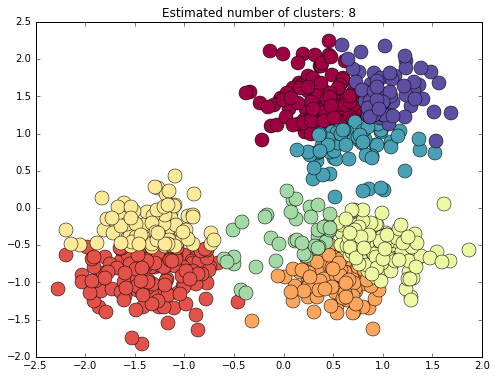

In [14]:
# 仿照DBSCAN的例子產生一樣的資料分群看看, 不給群數幾乎會亂分, 給定群數的話就比較符合預期
# 或者是可以找到一個適合的 threshold去限制群內半徑, 所以資料應該是要經過正規化之類的動作(normalize), 再來分群會比較好

from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import Birch

# Generate sample data
centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(n_samples=750, centers=centers, cluster_std=0.4,
                            random_state=0)

X = StandardScaler().fit_transform(X)
# 不給n_cluster其實結果會很慘...
clf = Birch(threshold=.5, n_clusters=None)
clf.fit(X)
labels = clf.labels_

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)

    xy = X[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)

plt.title('Estimated number of clusters: %d' % len(set(clf.labels_)))
plt.show()

Built-in functions, exceptions, and other objects.

Noteworthy: None is the `nil' object; Ellipsis represents `...' in slices.
Birch without global clustering as the final step took 4.54 seconds
n_clusters : 158
Birch with global clustering as the final step took 3.95 seconds
n_clusters : 100
Time taken to run MiniBatchKMeans 4.60 seconds


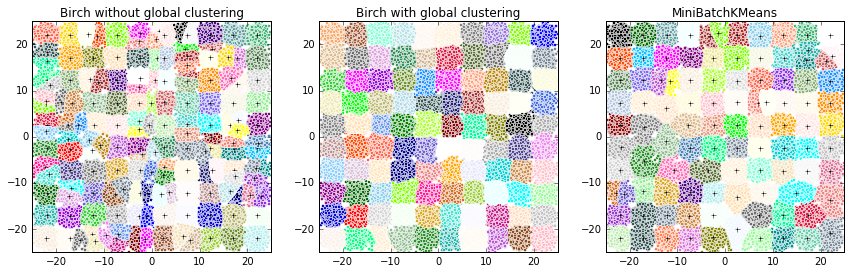

In [4]:
# 官方網站範例, birch 和 k-means的比較

# Authors: Manoj Kumar <manojkumarsivaraj334@gmail.com
#          Alexandre Gramfort <alexandre.gramfort@telecom-paristech.fr>
# License: BSD 3 clause

print(__doc__)

from itertools import cycle
from time import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import Birch, MiniBatchKMeans
from sklearn.datasets.samples_generator import make_blobs


# Generate centers for the blobs so that it forms a 10 X 10 grid.
xx = np.linspace(-22, 22, 10)
yy = np.linspace(-22, 22, 10)
xx, yy = np.meshgrid(xx, yy)
n_centres = np.hstack((np.ravel(xx)[:, np.newaxis],
                       np.ravel(yy)[:, np.newaxis]))

# Generate blobs to do a comparison between MiniBatchKMeans and Birch.
X, y = make_blobs(n_samples=100000, centers=n_centres, random_state=0)
   

# Use all colors that matplotlib provides by default.
colors_ = cycle(colors.cnames.keys())

fig = plt.figure(figsize=(12, 4))
fig.subplots_adjust(left=0.04, right=0.98, bottom=0.1, top=0.9)

# Compute clustering with Birch with and without the final clustering step
# and plot.
birch_models = [Birch(threshold=1.7, n_clusters=None),
                Birch(threshold=1.7, n_clusters=100)]
final_step = ['without global clustering', 'with global clustering']

for ind, (birch_model, info) in enumerate(zip(birch_models, final_step)):
    t = time()
    birch_model.fit(X)
    time_ = time() - t
    print("Birch %s as the final step took %0.2f seconds" % (
          info, (time() - t)))

    # Plot result
    labels = birch_model.labels_
    centroids = birch_model.subcluster_centers_
    n_clusters = np.unique(labels).size
    print("n_clusters : %d" % n_clusters)

    ax = fig.add_subplot(1, 3, ind + 1)
    for this_centroid, k, col in zip(centroids, range(n_clusters), colors_):
        mask = labels == k
        ax.plot(X[mask, 0], X[mask, 1], 'w',
                markerfacecolor=col, marker='.')
        if birch_model.n_clusters is None:
            ax.plot(this_centroid[0], this_centroid[1], '+', markerfacecolor=col,
                    markeredgecolor='k', markersize=5)
    ax.set_ylim([-25, 25])
    ax.set_xlim([-25, 25])
    ax.set_autoscaley_on(False)
    ax.set_title('Birch %s' % info)

# Compute clustering with MiniBatchKMeans.
mbk = MiniBatchKMeans(init='k-means++', n_clusters=100, batch_size=100,
                      n_init=10, max_no_improvement=10, verbose=0,
                      random_state=0)
t0 = time()
mbk.fit(X)
t_mini_batch = time() - t0
print("Time taken to run MiniBatchKMeans %0.2f seconds" % t_mini_batch)
mbk_means_labels_unique = np.unique(mbk.labels_)

ax = fig.add_subplot(1, 3, 3)
for this_centroid, k, col in zip(mbk.cluster_centers_,
                                 range(n_clusters), colors_):
    mask = mbk.labels_ == k
    ax.plot(X[mask, 0], X[mask, 1], 'w', markerfacecolor=col, marker='.')
    ax.plot(this_centroid[0], this_centroid[1], '+', markeredgecolor='k',
            markersize=5)
ax.set_xlim([-25, 25])
ax.set_ylim([-25, 25])
ax.set_title("MiniBatchKMeans")
ax.set_autoscaley_on(False)
plt.show()